## REFS: https://pdf.sciencedirectassets.com/271454/1-s2.0-S0263224121X00024/1-s2.0-S0263224121000129/main.pdf

In [1]:
import os
import numpy as np
import scipy.io
import pywt

from scipy.signal import hilbert, butter, lfilter
from matplotlib import pyplot as plt

from typing import List, Tuple
from kurtogram import fast_kurtogram

# Functions

In [2]:
def Load(file: str) -> Tuple[List]:

    DATA = scipy.io.loadmat(os.path.join('Data', file))
    x = DATA['bearing']['gs'][0][0]
    fs = DATA['bearing']['sr'][0][0][0]
    time = np.transpose(np.arange(0, len(x)) / fs)

    return x, fs, time, DATA


def PSD(f: List, time: List, num: int) -> Tuple[List]:

    dt = abs(time[2] - time[1])
    n = len(time[:num])
    fhat = np.fft.fft(f[:num], n)
    freq = (1/(dt*n))*np.arange(n)
    psd = fhat*np.conj(fhat) / n
    L = np.arange(1, np.floor(n/2), dtype='int')

    return freq, psd, L

def plot_psd(freq, psd, L, title=''):

    plt.figure()
    plt.plot(freq[L], psd[L])
    plt.xlim(freq[L[0]], freq[L[-1]])
    plt.xlabel('Freq [Hz]')
    plt.ylabel('Power Spectral Density')
    plt.title(f'PSD: {title}')




def Spec(f: List, fs: int, title: str=""):

    plt.figure()
    plt.title(title)
    plt.specgram(f, NFFT=1024, Fs=fs, noverlap=120,cmap='jet')
    plt.colorbar()


def wavelet_filter(coefficients, wavelet) -> List:
    
    coeff_arr, coeff_slices = pywt.coeffs_to_array(coefficients)

    Csort = np.sort(np.abs(coeff_arr.reshape(-1)))

    keep = 0.05

    thresh = Csort[int(np.floor((1-keep)*len(Csort)))]
    ind = np.abs(coeff_arr) > thresh
    Cfilt = coeff_arr * ind # Threshold small indices

    coeffs_filt = pywt.array_to_coeffs(Cfilt,coeff_slices,output_format='wavedec')

    # Plot reconstruction
    Arecon = pywt.waverec(coeffs_filt,wavelet=wavelet)

    return Arecon

def band_pass(signal, low, high, fs, order=5):
    nyquist = 0.5*fs
    low = low / nyquist
    high = high / nyquist
    b, a = butter(N=order, Wn=[low, high], fs=fs, btype='band')
    return lfilter(b, a, signal)


def env_spectrum(x, fs, BAND=False, LOW=0, HIGH=0):

    if BAND:
        if not LOW or not HIGH:
            raise AttributeError("Frequency Band not determined. Can't be zero!")
        x = band_pass(x, LOW, HIGH, fs[0])

    analytic_signal = hilbert(x)
    envelope = np.abs(analytic_signal)

    # y_d = np.gradient(np.abs(x))
    # analytic_signal = hilbert(y_d)
    # envelope = np.abs(analytic_signal)
    
    
    f_env = np.fft.fftfreq(len(envelope), d=1/fs)
    p_env = np.abs(np.fft.rfft(envelope) / len(x))
    
    
    x_env = envelope
    
    return p_env, f_env, x_env, 


def plot_env_spectrum(x_env, x_raw, time):

    plt.figure()
    plt.subplot(2, 1, 1)
    plt.xlim(0.04, 0.06)
    plt.plot(time, x_raw)
    plt.xlabel('Time [s]')
    plt.ylabel('Acceletarion [g]')
    plt.subplot(2, 1, 2)
    plt.plot(time[:len(x_env)], x_env)
    plt.xlim(0.04, 0.06)
    # plt.ylim(0, 1)
    plt.xlabel('Time [s]')
    plt.ylabel('Acceletarion [g]')

def plot_env_spectrum_analysis(f_env, p_env, BP, BPFI=False, BPFO=False, ALL=False):
    
    k = 0
    ncomb = 0
    if ALL: BPFI = BPFO = True

    plt.figure()
    a = next((index for index, value in enumerate(f_env) if value > 1000), -1)
    plt.plot(f_env[3:a], p_env[3:a], label='Envelope Spectrum')
    plt.xlabel("Frequency [Hz]")
    plt.ylabel('Peak Amplitude')
    plt.xlim(0, 1000)
    plt.ylim( 0, 0.5)

    if BPFI:
        values = []
        while k * BP["BPFI"] < 1000: 
            values.append(k * BP["BPFI"])
            k +=1
        harmonics = dict(values=values, name="BPFI")
        plt.vlines(harmonics['values'], 0, 0.5, colors='r', linestyles='--', label=harmonics['name'])
    if BPFO:
        values = []
        while ncomb * BP["BPFO"] < 1000: 
            values.append(ncomb * BP["BPFO"])
            ncomb +=1
        harmonics = dict(values=values, name="BPFO")
        plt.vlines(harmonics['values'], 0, 0.5, colors='#f87915', linestyles='--', label=harmonics['name'])

    plt.legend(framealpha=1)




# Analysis

## Inner Fault 1

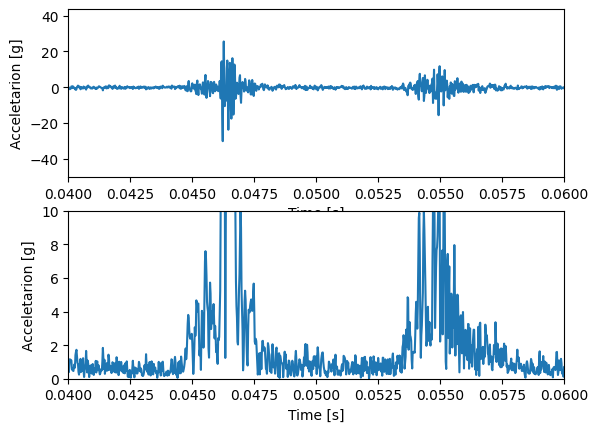

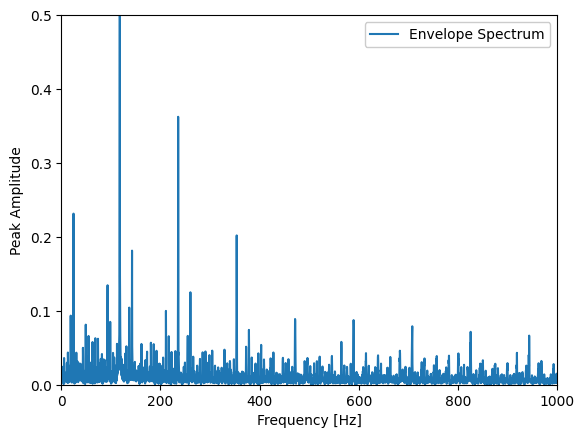

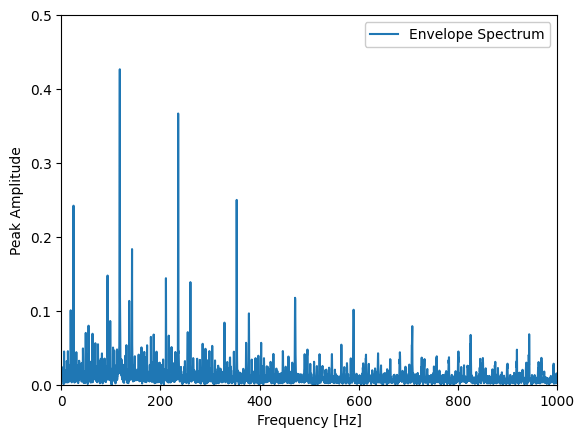

In [3]:
file_to_load = 'InnerRaceFault_vload_1.mat'
title = file_to_load.split('.')[0]


x_IRF_1, f_IRF_1, t_IRF_1, IRFDATA = Load(file_to_load)



num = int(len(t_IRF_1)*0.001)

freq, psd, L = PSD(x_IRF_1, t_IRF_1, num)

# plot_psd(freq, psd, L, title)

# Spec(np.transpose(x_IRF_1[:num])[0], f_IRF_1[0], title)

p_env, f_env, x_env = env_spectrum(np.transpose(x_IRF_1[:])[0],  f_IRF_1[0])



plot_env_spectrum(x_env, x_IRF_1, t_IRF_1)
plt.ylim(0, 10)

plot_env_spectrum_analysis(f_env, p_env, IRFDATA)

# Wavelet

wavelet='db1'
scales = (1, len(x_IRF_1))
coeffs = pywt.wavedec(x_IRF_1, wavelet)

recon = wavelet_filter(coeffs, wavelet)
title = "Recon Inner Fault 1"

p_env, f_env, x_env = env_spectrum(np.transpose(recon)[0],  f_IRF_1[0])


plot_env_spectrum_analysis(f_env, p_env, IRFDATA)





## Baseline 1

c:\Users\dimit\OneDrive\Documentos\Python\CienDados\env\Lib\site-packages\matplotlib\cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\dimit\OneDrive\Documentos\Python\CienDados\env\Lib\site-packages\matplotlib\cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


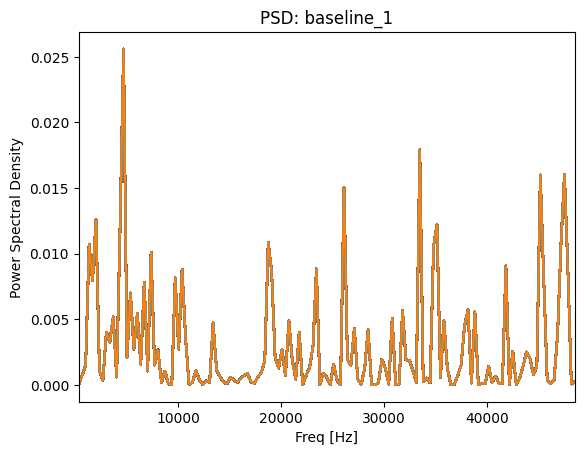

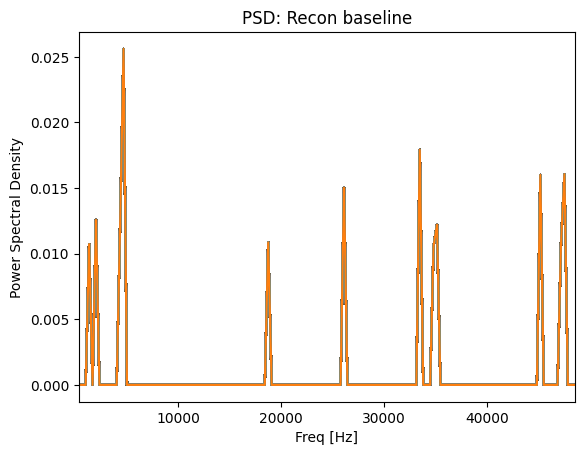

In [4]:
file_to_load = 'baseline_1.mat'
title = file_to_load.split('.')[0]

x_bsln_1, f_bsln_1, t_bsln_1, BSLN_DATA = Load(file_to_load)
num = int(len(t_bsln_1)*0.0005)

freq, psd, L = PSD(x_bsln_1, t_bsln_1, num)

plot_psd(freq, psd, L, title)


# Spec(np.transpose(x_bsln_1[:num])[0], f_bsln_1[0], title)


#Wavelet test

wavelet='db1'
scales = (1, len(x_bsln_1))
coeffs = pywt.wavedec(x_bsln_1, wavelet)

recon = wavelet_filter(coeffs, wavelet)
title = "Recon baseline"

freq, psd, L = PSD(recon, t_bsln_1, num)

plot_psd(freq, psd, L, title)

# Spec(np.transpose(recon[:num])[0], f_bsln_1[0], title='Recon')


## Envelope Spectrum: Normal

(0.0, 0.02)

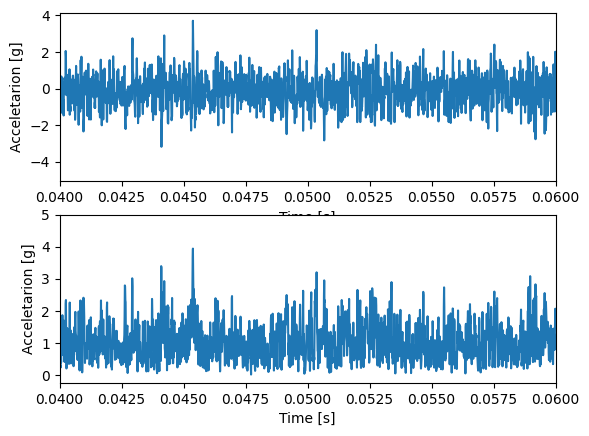

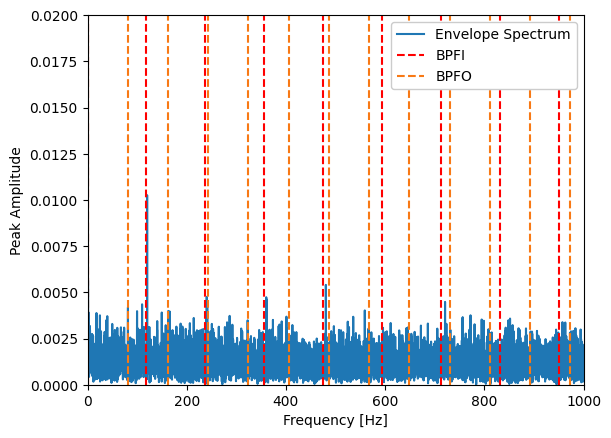

In [5]:
p_env, f_env, x_env = env_spectrum(np.transpose(x_bsln_1)[0],  f_bsln_1[0])

plot_env_spectrum(x_env, x_bsln_1, t_bsln_1)

plot_env_spectrum_analysis(f_env, p_env, BSLN_DATA, ALL=True)
plt.ylim(0, 2E-2)


# Outer Fault Analysis


In [6]:
file_to_load = 'OuterRaceFault_2.mat'
title = file_to_load.split('.')[0]

x_ORF_2, f_ORF_2, t_ORF_2, ORF_DATA = Load(file_to_load)
num = int(len(t_ORF_2)*0.0005)

freq, psd, L = PSD(x_ORF_2, t_ORF_2, num)

# plot_psd(freq, psd, L, title)


# Spec(np.transpose(x_ORF_2[:num])[0], f_ORF_2[0], title)


#Wavelet test

# wavelet='db1'
# scales = (1, len(x_ORF_2))
# coeffs = pywt.wavedec(x_ORF_2, wavelet)

# recon = wavelet_filter(coeffs, wavelet)
# title = "Recon baseline"

# freq, psd, L = PSD(recon, t_ORF_2, num)

# plot_psd(freq, psd, L, title)

# Spec(np.transpose(recon[:num])[0], f_bsln_1[0], title='Recon')

## Envelope Spectrum: Outer Fault

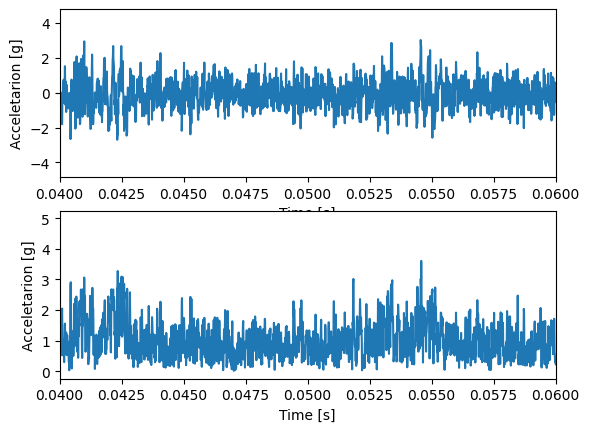

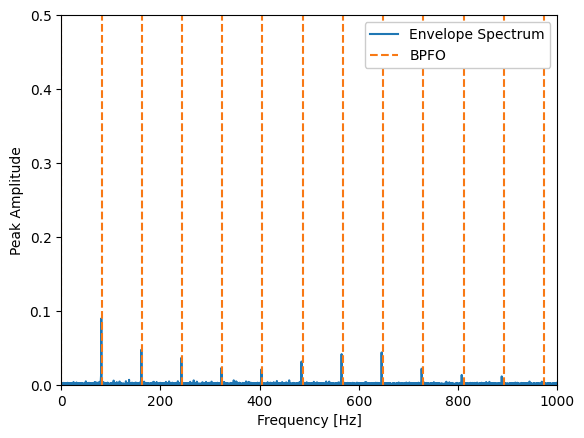

In [7]:
p_env, f_env, x_env = env_spectrum(np.transpose(x_ORF_2)[0],  f_ORF_2[0])

plot_env_spectrum(x_env, x_ORF_2, t_ORF_2)

plot_env_spectrum_analysis(f_env, p_env, ORF_DATA, BPFO=True)
# plt.ylim(0, 0.1)

# TUDO TESTE AQUI PRA BAIXO

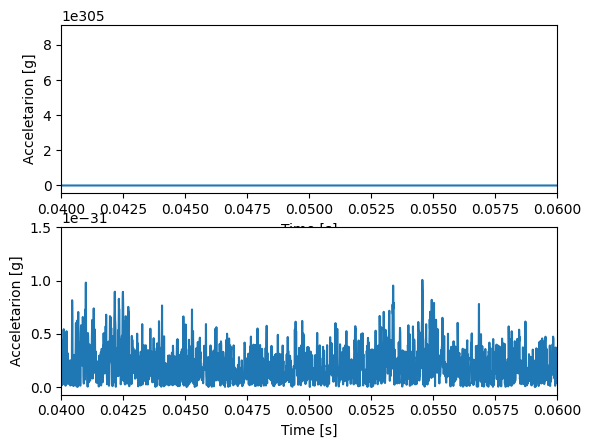

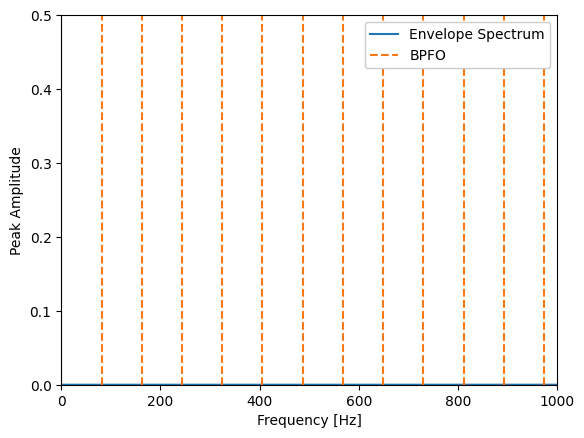

In [10]:
# from scipy.signal import butter, lfilter


# def band_pass(signal, low, high, fs, order=5):
#     b, a = butter(N=order, Wn=[low, high], fs=fs, btype='band')
#     return lfilter(b, a, signal)


Kwav, Level_w, freq_w, c, max_Kurt, BW, level_max = fast_kurtogram(x_ORF_2, f_ORF_2, 9)   # Center frequency & bandwidth obtained from kurtogram
minw = np.where(Level_w == level_max)[0][0]
kurtw = np.where(Kwav[minw, :] == max_Kurt)[0][0]
bandw = freq_w[kurtw]
fc = bandw + BW[0]/2

low = fc - BW/2
high = fc + BW/2

## ERRADO: VER COMO APLICAR O FILTRO DE FREQ NESSE SINAL Q TA NO TEMPO (NO MATLAB TA ASSIM)
x_ORF_2_Bpf = band_pass(np.transpose(x_ORF_2)[0], low, high, f_ORF_2[0])

p_env_ORF_2_Bpf, f_env_ORF_2_Bpf, x_env_ORF_2_Bpf = env_spectrum(x_ORF_2, f_ORF_2, BAND=1, LOW=low, HIGH=high)



plot_env_spectrum(x_env_ORF_2_Bpf, x_ORF_2_Bpf, t_ORF_2)

plot_env_spectrum_analysis(f_env_ORF_2_Bpf, p_env_ORF_2_Bpf, ORF_DATA, BPFO=True)


In [29]:
pywt.cwt(np.transpose(x_ORF_2)[0][:5], 2, 'gaus1')

(array([[-0.3646155 , -0.53587924, -0.45282098,  0.10009352,  0.61933131]]),
 array([0.1]))

# Kurtogram Analysis

C:\Users\dimit\AppData\Local\Temp\ipykernel_13932\4121190797.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  xlavel = np.array(np.arange(0, f_ORF_2/2+f_ORF_2/2/7, f_ORF_2/2/7), dtype=int)


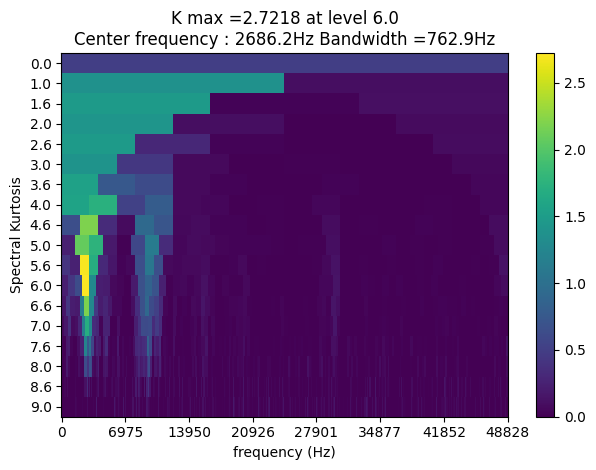

In [24]:


Kwav, Level_w, freq_w, fc, max_Kurt, bandwidth, level_max = fast_kurtogram(x_ORF_2, f_ORF_2, 9)   # Center frequency & bandwidth obtained from kurtogram
minw = np.where(Level_w == level_max)[0][0]
kurtw = np.where(Kwav[minw, :] == max_Kurt)[0][0]
bandw = freq_w[kurtw]
ax = plt.gca()
im = ax.imshow(Kwav, interpolation='none', aspect='auto')
xlavel = np.array(np.arange(0, f_ORF_2/2+f_ORF_2/2/7, f_ORF_2/2/7), dtype=int)
plt.xticks(np.arange(0, Kwav.shape[1], Kwav.shape[1] // 7), labels=xlavel)
plt.title(f'K max ={max_Kurt:.4f} at level {level_max:.1f}\nCenter frequency : {bandw + bandwidth[0]/2:.1f}Hz Bandwidth ={bandwidth[0]:.1f}Hz')
plt.xlabel('frequency (Hz)')
plt.yticks(np.arange(0, Kwav.shape[0], 1), labels=np.round(Level_w, 1))
plt.ylabel('level (window lenght)')

plt.colorbar(im)

plt.ylabel('Spectral Kurtosis')
plt.tight_layout()

C:\Users\dimit\AppData\Local\Temp\ipykernel_21040\4025130338.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  xlavel = np.round(np.array(np.arange(0, f_ORF_2/2+f_ORF_2/2/7, f_ORF_2/2/7), dtype=int)*1E-3, 2)


Text(0, 0.5, 'level (window lenght)')

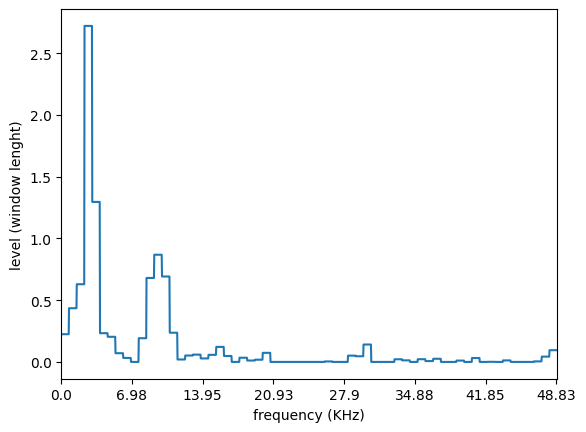

In [31]:
plt.plot(Kwav[11])
xlavel = np.round(np.array(np.arange(0, f_ORF_2/2+f_ORF_2/2/7, f_ORF_2/2/7), dtype=int)*1E-3, 2)
plt.xticks(np.arange(0, Kwav.shape[1], Kwav.shape[1] // 7), labels=xlavel)
plt.xlabel('frequency (KHz)')
plt.xlim(0, len(Kwav[11]))
# plt.yticks(np.arange(0, Kwav.shape[0], 1), labels=np.round(Level_w, 1))
plt.ylabel('level (window lenght)')

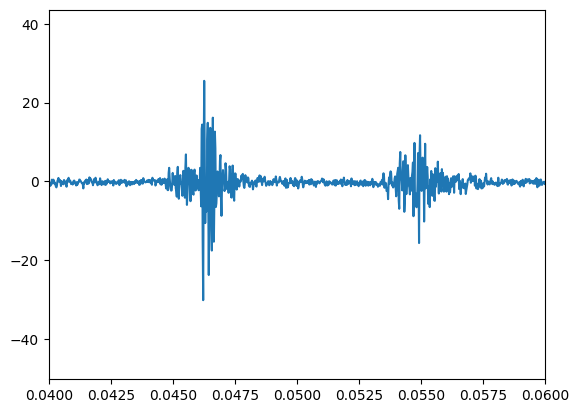

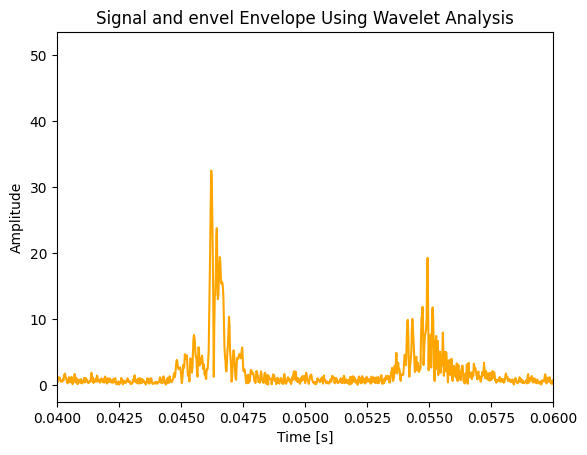

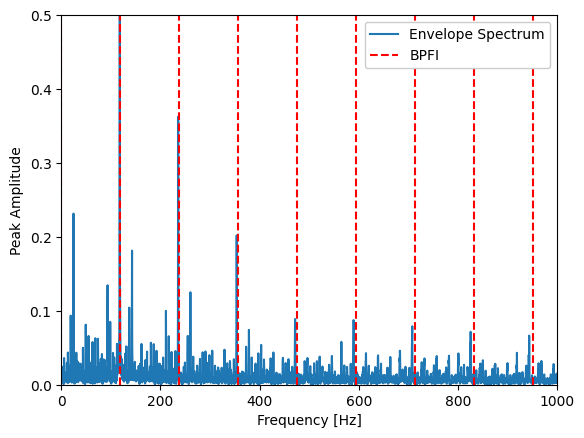

In [32]:
# from scipy.signal import demod
# cA, _ = pywt.cwt(x_IRF_1, k[4],  'cmor')
file_to_load = 'InnerRaceFault_vload_1.mat'


x_IRF_1, f_IRF_1, t_IRF_1, IRFDATA = Load(file_to_load)
x_IRF_1 = np.transpose(x_IRF_1)[0]
# t_IRF_1 = np.transpose(t_IRF_1)


wavelet = 'db1'  # Daubechies wavelet
coeffs = pywt.wavedec(x_IRF_1, wavelet)

# Get the approximation coefficients
cA = coeffs[0]

# Create the envelope by upsampling the approximation coefficients
# [[[[QUASE]]]]

p_env, f_env, x_env = env_spectrum(x_IRF_1, f_IRF_1)


plt.plot(t_IRF_1, x_IRF_1, label='Original Signal')
plt.xlim(0.04, 0.06)

plt.figure()
plt.plot(t_IRF_1, x_env[:len(t_IRF_1)], label='Envelope', color='orange')
plt.title('Signal and envel Envelope Using Wavelet Analysis')
plt.xlim(0.04, 0.06)
# plt.ylim(0, 10)
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')


plot_env_spectrum_analysis(f_env, p_env, IRFDATA, BPFI=True)
# plt.legend()